In [54]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns

edges = pd.read_csv('C:/Users/admin/3D Objects/Network Analysis Winter 2025/Testing Project/edges.csv')
edges.columns = edges.columns.str.strip().str.replace('#', "")

G = nx.from_pandas_edgelist(
    edges,
    source=' source',
    target='target',
    edge_attr=["rating", "time"],
    create_using=nx.DiGraph
)

print(f'Graph G, {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')

Graph G, 5881 nodes, 35592 edges


Our Bitcoin network is a Weighted Directed Network with 5881 nodes and 35592 edges. Each directed edge (i,j,w) represents the rating of user j by user i, in which i assigns j a weight w on a scale of -10 (total distrust) to +10 (total trust)

In [2]:
density = nx.density(G)
clustering = nx.average_clustering(G.to_undirected())
weaklyconnected = nx.weakly_connected_components(G)
stronglyconnected = nx.strongly_connected_components(G)
print(f'Density score: {density}')
print(f'Average clustering: {clustering}')


Density score: 0.0010292571373048454
Average clustering: 0.17750449405289492


Here as expected, the network is extremely sparse. The network also has an average clustering of only 0.17 which mean that there are only 17% chance that i will trust j through another node k. This shows that bitcoin user trust their cryptomate on local level

In [3]:
# Weakly connected components
wcc = list(nx.weakly_connected_components(G))
print("Number of WCCs:", len(wcc))
largest_wcc = max(wcc, key=len)
print("Size of largest WCC:", len(largest_wcc))

# Strongly connected components
scc = list(nx.strongly_connected_components(G))
print("Number of SCCs:", len(scc))
largest_scc = max(scc, key=len)
print("Size of largest SCC:", len(largest_scc))


Number of WCCs: 4
Size of largest WCC: 5875
Number of SCCs: 1144
Size of largest SCC: 4709


The network is mostly connected. Only have 4 isolated users if we ignore direction. Many users are part of a trust core group, however we can see many small SCC which imply a peripheral trust edges relationship where an users only trust another single user.

Numbers of in degree: 5881, Numbers of out degree: 5881


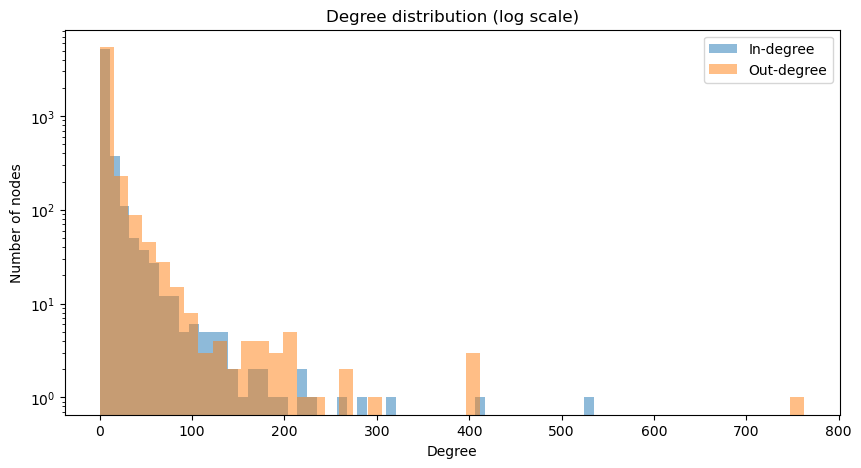

In [4]:
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

print(f'Numbers of in degree: {len(in_degree)}, Numbers of out degree: {len(out_degree)}')

plt.figure(figsize=(10,5))
plt.hist(list(in_degree.values()), bins=50, alpha=0.5, label='In-degree', log=True)
plt.hist(list(out_degree.values()), bins=50, alpha=0.5, label='Out-degree', log=True)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree distribution (log scale)")
plt.legend()
plt.show()

As above we can see that there are some significant hubs which attract over 400 degrees. It is also shown in the histogram and the CCDF that it follow the usual power law with tailed heavy property.

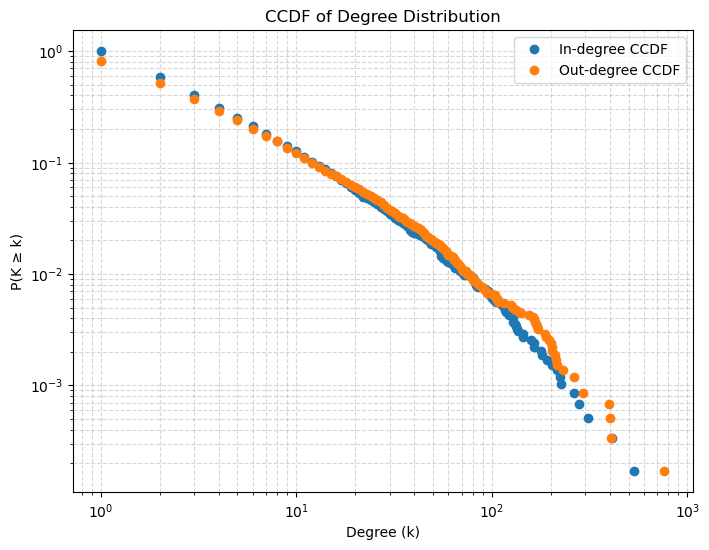

In [7]:
def compute_ccdf(degree_dict):
    # Get degree values as a sorted numpy array
    degrees = np.array(list(degree_dict.values()))
    unique_degrees = np.sort(np.unique(degrees))
    
    # CCDF: fraction of nodes with degree >= k
    ccdf = [np.sum(degrees >= k)/len(degrees) for k in unique_degrees]
    
    return unique_degrees, ccdf

in_deg_vals, in_ccdf = compute_ccdf(in_degree)
out_deg_vals, out_ccdf = compute_ccdf(out_degree)

plt.figure(figsize=(8,6))
plt.plot(in_deg_vals, in_ccdf, marker='o', linestyle='none', label='In-degree CCDF')
plt.plot(out_deg_vals, out_ccdf, marker='o', linestyle='none', label='Out-degree CCDF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title("CCDF of Degree Distribution")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()



In [ ]:
# Read nodes CSV
nodes_df = pd.read_csv("nodes.csv")

nodes_df.columns = (
    nodes_df.columns
    .str.strip()              # remove spaces
    .str.replace("#", "", regex=False)  # remove '#'
    .str.strip()              # clean again
)
#"_pos" strings into actual numpy arrays
nodes_df['_pos'] = nodes_df['_pos'].apply(
    lambda x: np.array(ast.literal_eval(x.replace("array", "")))
)

#Build a position dictionary {node_id: np.array([x, y])}
pos_dict = nodes_df.set_index('name')['_pos'].to_dict()

#Attach positions as node attributes to your existing graph G
nx.set_node_attributes(G, pos_dict, 'pos')

Nodes with positions: 5881/5881


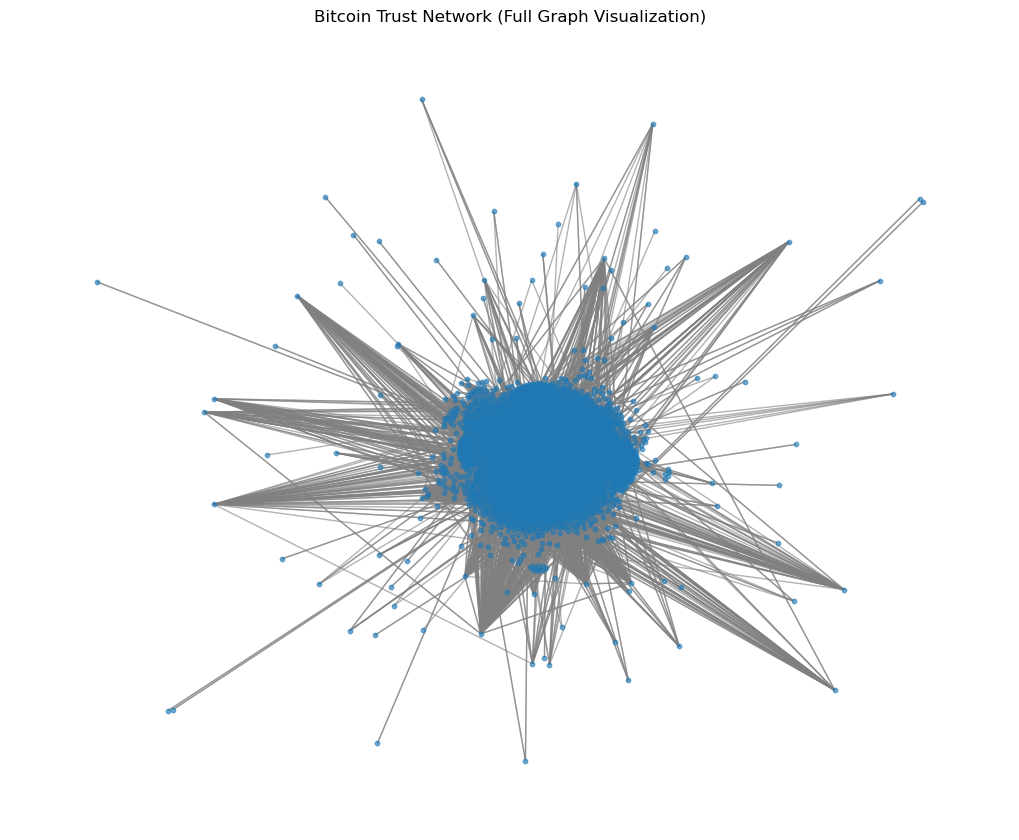

In [24]:
import numpy as np

# For nodes without pos, assign random positions around the mean of existing ones
existing_pos = np.array(list(pos_dict.values()))
mean_pos = existing_pos.mean(axis=0)

for n in G.nodes():
    if 'pos' not in G.nodes[n]:
        G.nodes[n]['pos'] = mean_pos + np.random.normal(scale=0.1, size=2)

has_pos = sum(['pos' in d for _, d in G.nodes(data=True)])
print(f"Nodes with positions: {has_pos}/{G.number_of_nodes()}")

import matplotlib.pyplot as plt
import networkx as nx

# get all node positions
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    node_size=10,
    alpha=0.6,
    arrows=False,
    edge_color='gray'
)
plt.title("Bitcoin Trust Network (Full Graph Visualization)")
plt.axis('off')
plt.show()


Original edges: 21492, Backbone edges: 1025
Original nodes: 5881, Backbone nodes: 1052


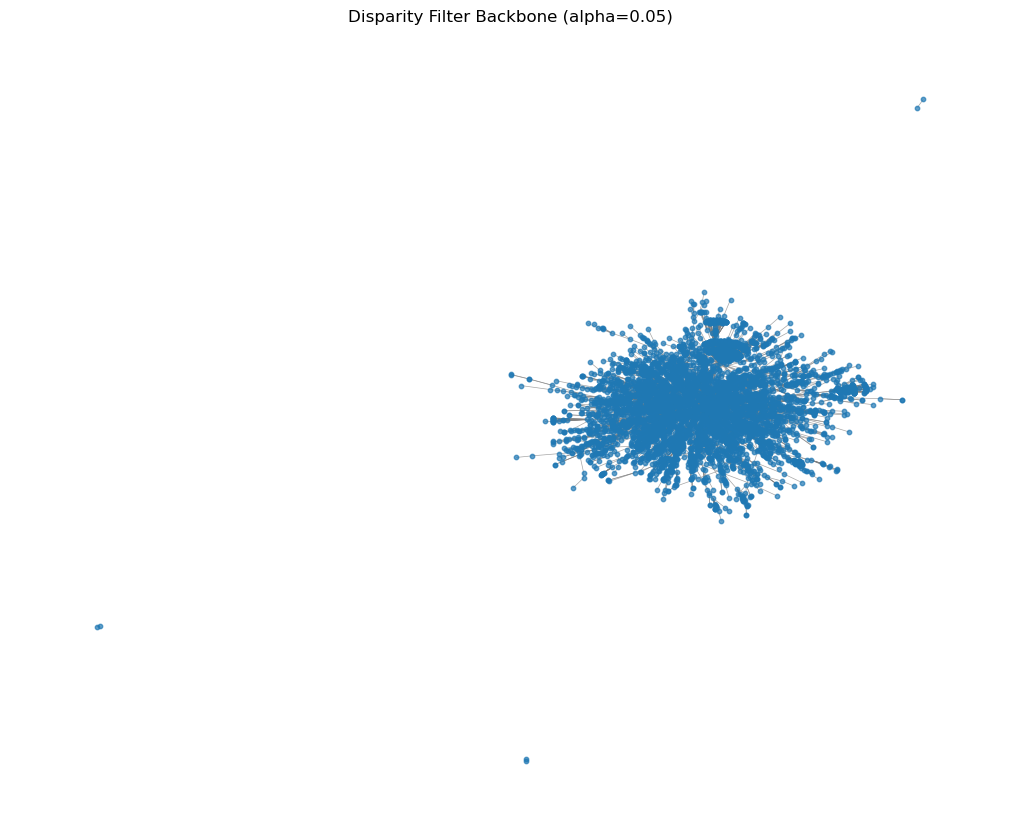

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Step 0: convert your directed graph to undirected for the backbone ---
U = nx.Graph()
for u, v, d in G.edges(data=True):
    w = abs(d.get('rating',0))  # use abs() if signed edges
    if U.has_edge(u,v):
        U[u][v]['weight'] += w
    else:
        U.add_edge(u,v, weight=w)

# --- Step 1: disparity filter function ---
def disparity_filter(G, weight='weight', alpha=0.05):
    H = nx.Graph()
    for u in G.nodes():
        nbrs = list(G[u].items())
        k = len(nbrs)
        if k < 2:
            continue
        s = sum(d.get(weight,0) for v,d in nbrs)
        for v,d in nbrs:
            w = d.get(weight,0)
            p_ij = w / s
            alpha_ij = (1 - p_ij)**(k - 1)
            if alpha_ij < alpha:
                H.add_edge(u, v, **{weight: w})
    return H

# --- Step 2: apply disparity filter ---
alpha = 0.05  # significance level
U_backbone = disparity_filter(U, weight='weight', alpha=alpha)

print(f"Original edges: {U.number_of_edges()}, Backbone edges: {U_backbone.number_of_edges()}")
print(f"Original nodes: {U.number_of_nodes()}, Backbone nodes: {U_backbone.number_of_nodes()}")

# --- Step 3: (Optional) MST to preserve connectivity ---
mst = nx.maximum_spanning_tree(U)
for u,v,d in mst.edges(data=True):
    if not U_backbone.has_edge(u,v):
        U_backbone.add_edge(u,v, weight=d['weight'])

# --- Step 4: visualize ---
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10,8))
nx.draw(U_backbone, node_size=10, alpha=0.7, edge_color='gray', width=0.5, with_labels=False)
plt.title(f"Disparity Filter Backbone (alpha={alpha})")
plt.axis('off')
plt.show()


   year  total_edges  positive_edges  negative_edges  avg_rating  max_rating  \
0  2010          142             142               0    2.753521          10   
1  2011         7758            7603             155    1.721191          10   
2  2012         9432            8622             810    1.199746          10   
3  2013        12982           11138            1844    0.466030          10   
4  2014         4225            3555             670    0.814201          10   
5  2015         1011             929              82    1.373887          10   
6  2016           42              40               2    1.928571           7   

   min_rating  
0           1  
1         -10  
2         -10  
3         -10  
4         -10  
5         -10  
6         -10  


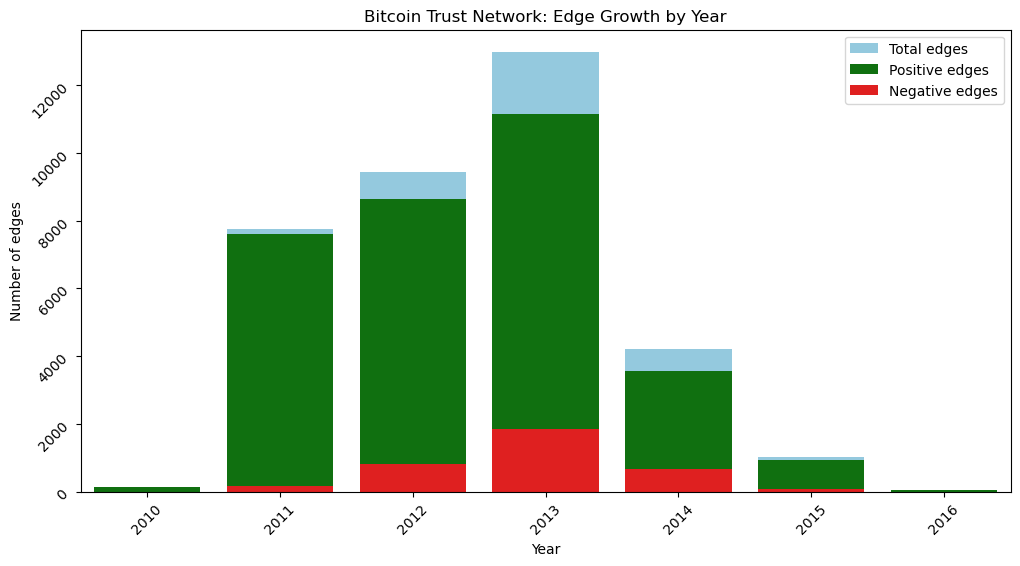

In [59]:
edges['time'] = pd.to_datetime(edges['time'], unit='s')
edges['year'] = edges['time'].dt.year

# Summarize by year
yearly_summary = edges.groupby('year').agg(
    total_edges=('rating', 'count'),                    # number of edges
    positive_edges=('rating', lambda x: (x > 0).sum()), # count positive ratings
    negative_edges=('rating', lambda x: (x < 0).sum()), # count negative ratings
    avg_rating=('rating', 'mean'),                     # average rating
    max_rating=('rating', 'max'),                      # max rating
    min_rating=('rating', 'min')                       # min rating
).reset_index()

print(yearly_summary)

plt.figure(figsize=(12,6))

# Plot total edges per year
sns.barplot(x='year', y='total_edges', data=yearly_summary, color='skyblue', label='Total edges')

# Overlay positive edges
sns.barplot(x='year', y='positive_edges', data=yearly_summary, color='green', label='Positive edges')

# Overlay negative edges
sns.barplot(x='year', y='negative_edges', data=yearly_summary, color='red', label='Negative edges')

plt.xlabel("Year")
plt.ylabel("Number of edges")
plt.title("Bitcoin Trust Network: Edge Growth by Year")
plt.legend()
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Looking at the bar plot, it show that the crypto wave take a massive boom at the year 2011. However, the growth rate stagnate drop at the year 2014 and even lower for the following year. In term of negative/positive edge proportion, the year 2011 and 2010's proportion are overly positive but 2012 and especially 2013 a not so small proportion of user show concern over crypto. The following years of 2014 and 2015 also point at similar trends but as mentioned above the amound of edges contribute to the entire network is not too significant.

For my research question, I propose "How did trust interactions in the Bitcoin network evolve year by year, particularly during the 2011 boom and the 2014 slowdown, and how did the proportion of positive vs negative edges reflect changing user sentiment?”

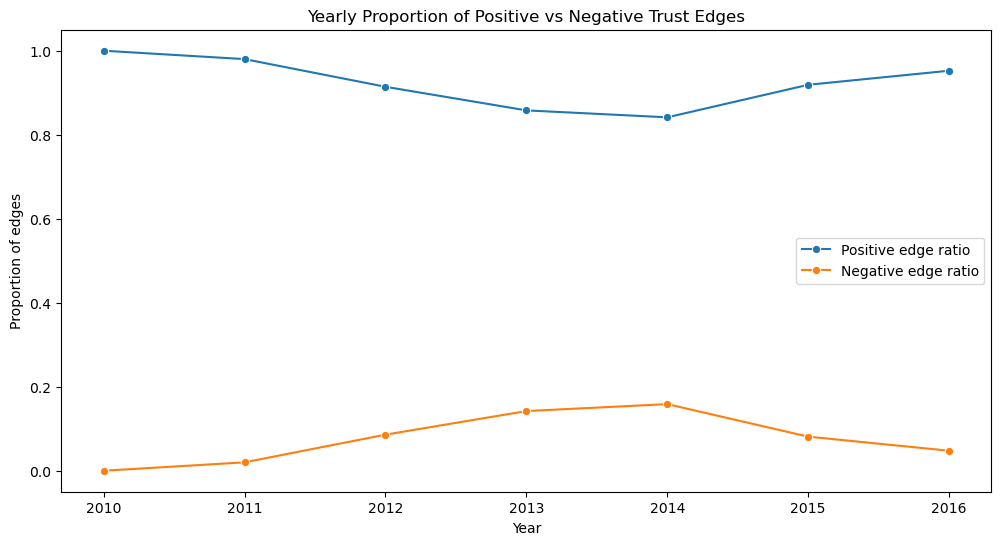

In [ ]:
yearly_summary['pos_ratio'] = yearly_summary['positive_edges'] / yearly_summary['total_edges']
yearly_summary['neg_ratio'] = yearly_summary['negative_edges'] / yearly_summary['total_edges']

plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='pos_ratio', data=yearly_summary, marker='o', label='Positive edge ratio')
sns.lineplot(x='year', y='neg_ratio', data=yearly_summary, marker='o', label='Negative edge ratio')
plt.xlabel("Year")
plt.ylabel("Proportion of edges")
plt.title("Yearly Proportion of Positive vs Negative Trust Edges")
plt.legend()
plt.show()